## Predicting single cells response to kinase inhibitors in breast cancer

#### Contributors:

**Name:** Angelo Digirolamo  
**UNI:** ajd2220

**Name:** Antoine Andurao  
**UNI:** ala2213

**Name:** Eleni Savidis  
**UNI:** eis2132

**Name:** Valentina Muti  
**UNI:** vbm2108

In [1]:
# MOUNTING GOOGLE DRIVE WHERE DATA IS STORED
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

Mounted at /gdrive


## Data loading

This code snippet loads the data from single cell phosphorylaion, as Pandas Dataframes. You should make sure your running env has enough memory to do so, and consider GPU-acceleration in order to train the NN furter down faster (choose T4 GPU in Colab).

In [4]:
import pandas as pd
import os

PATH = "/gdrive/My Drive/ECBM Project/"

data_paths = []

'''
Data from the DREAM Challenge is structured in an uncanny way. This code below retrieves all CSV files from the whole
DATA folder, combing through all subfolders.
'''

for root, dirs, files in os.walk(PATH + "DATA/"):
    for file in files:
        file_path = os.path.join(root, file)
        if(file_path.endswith(".csv")):
          data_paths.append(file_path)

In [5]:
'''
Names of all cell lines available in this challenge has been stored in "cell_lines.txt
'''
try:
    with open(PATH + "cell_lines.txt", 'r') as file:
        # Read the lines from the file
        cell_lines = file.readlines()

        # Remove any leading or trailing whitespaces
        cell_lines = [line.strip() for line in cell_lines]

        # Now 'cell_lines' contains the elements of the list
        print("List of all cell lines available for the challenge: " + str(cell_lines))
except Exception as e:
    print(f"An error occurred: {e}")

List of all cell lines available for the challenge: ['184A1', '184B5', 'MPE600', 'AU565', 'BT20', 'BT474', 'BT483', 'BT549', 'CAL120', 'CAL148', 'CAL51', 'CAL851', 'CAMA1', 'DU4475', 'EFM19', 'EFM192A', 'EVSAT', 'HBL100', 'HCC1143', 'HCC1187', 'HCC1395', 'HCC1419', 'HCC1428', 'HCC1500', 'HCC1569', 'HCC1599', 'HCC1806', 'HCC1937', 'HCC1954', 'HCC202', 'HCC2185', 'HCC2218', 'HCC3153', 'HCC38', 'HCC70', 'HDQP1', 'Hs578T', 'JIMT1', 'KPL1', 'LY2', 'MACLS2', 'MCF10A', 'MCF12A', 'MCF7', 'MDAMB134VI', 'MDAMB157', 'MDAMB175VII', 'MDAMB231', 'MDAMB361', 'MDAMB415', 'MDAMB436', 'MDAMB453', 'MDAMB468', 'MFM223', 'MX1', 'OCUBM', 'SKBR3', 'T47D', 'UACC3199', 'UACC812', 'UACC893', 'ZR751', 'ZR7530', 'ZR75B']


In [6]:
'''
Using the list of paths to CSV files retrieved earlier, we single out the ones corresponding to
the cell lines of the challenge, and store these paths into a list ("cell_line_pahts") for further loading
'''

cell_line_paths = []

for path in data_paths:
  file_name, file_ext = os.path.splitext(os.path.basename(path))
  if(cell_lines.count(file_name) > 0 and file_ext == '.csv'):
    cell_line_paths.append(path)


print(f"Paths to the single cell phospholytion data for each of the {len(cell_line_paths)} cell lines: {cell_line_paths}")

Paths to the single cell phospholytion data for each of the 64 cell lines: ['/gdrive/My Drive/ECBM Project/DATA/1/42212001/MDAMB157.csv', '/gdrive/My Drive/ECBM Project/DATA/101/42212101/MFM223.csv', '/gdrive/My Drive/ECBM Project/DATA/109/42212109/MPE600.csv', '/gdrive/My Drive/ECBM Project/DATA/125/42212125/MX1.csv', '/gdrive/My Drive/ECBM Project/DATA/140/42211140/HCC1937.csv', '/gdrive/My Drive/ECBM Project/DATA/145/42212145/OCUBM.csv', '/gdrive/My Drive/ECBM Project/DATA/149/42212149/T47D.csv', '/gdrive/My Drive/ECBM Project/DATA/155/42212155/UACC812.csv', '/gdrive/My Drive/ECBM Project/DATA/165/42212165/UACC893.csv', '/gdrive/My Drive/ECBM Project/DATA/176/42212176/ZR7530.csv', '/gdrive/My Drive/ECBM Project/DATA/19/42211019/HCC1569.csv', '/gdrive/My Drive/ECBM Project/DATA/21/42211021/HCC1599.csv', '/gdrive/My Drive/ECBM Project/DATA/22/42212022/MDAMB361.csv', '/gdrive/My Drive/ECBM Project/DATA/238/42304238/AU565.csv', '/gdrive/My Drive/ECBM Project/DATA/238/42211238/HCC1954.cs

In [7]:
'''

Given the path to a cell line phosphorylation data, this function returns a Dataframe containing
the cell line data, grouped by condition (and cell line), with the mean and variance for each of the 37 markers.
The process of this conversion from single cell values to distribution statistics is detailed in the paper.

'''
def get_data_from_csv(path):
  df = pd.read_csv(path)
  df.insert(0, "condition", df['treatment'].astype('str') + "_" + df['time'].astype('str')) # Creating the condition feature by merging time point and treatment
  df.drop(['fileID', 'cellID', 'treatment', 'time'], axis=1, inplace=True) # Single cell info is dropped since only statistics will be considered
  # Data is grouped by condition (and cell line) so that statistics can be computed for each group
  group_df = df.groupby(['condition', 'cell_line'])
  df = pd.merge(group_df[df.columns.values.tolist()[2:]].mean().add_suffix('_mean'), group_df[df.columns.values.tolist()[2:]].var().add_suffix('_var'), on=['condition', 'cell_line'], how='inner')
  return df

In [8]:
'''

For each cell line in cell_line_paths, a Dataframe with statistics per condition is loaded using get_data_from_csv()
and these Dataframe are all concatenated into one Dataframe, representing our whole dataset.

'''

import gc

concatenated_df  = get_data_from_csv(cell_line_paths[0])
print("Loading cell line number {}: {}".format(1, os.path.splitext(os.path.basename(cell_line_paths[0]))[0]))

i = 1
# Read each CSV file and append its DataFrame to the list
for i in range(1, len(cell_line_paths)):
    df = get_data_from_csv(cell_line_paths[i])
    print("Loading cell line number {}: {}".format(i+1, os.path.splitext(os.path.basename(cell_line_paths[i]))[0]))
    concatenated_df = pd.concat([concatenated_df, df])
    try:
      del df
      gc.collect()
    except:
      pass

Loading cell line number 1: MDAMB157
Loading cell line number 2: MFM223
Loading cell line number 3: MPE600
Loading cell line number 4: MX1
Loading cell line number 5: HCC1937
Loading cell line number 6: OCUBM
Loading cell line number 7: T47D
Loading cell line number 8: UACC812
Loading cell line number 9: UACC893
Loading cell line number 10: ZR7530
Loading cell line number 11: HCC1569
Loading cell line number 12: HCC1599
Loading cell line number 13: MDAMB361
Loading cell line number 14: AU565
Loading cell line number 15: HCC1954
Loading cell line number 16: EFM19
Loading cell line number 17: HCC2218
Loading cell line number 18: LY2
Loading cell line number 19: MDAMB175VII
Loading cell line number 20: HCC2185
Loading cell line number 21: MDAMB415
Loading cell line number 22: MACLS2
Loading cell line number 23: HCC1500
Loading cell line number 24: 184A1
Loading cell line number 25: BT20
Loading cell line number 26: HCC3153
Loading cell line number 27: MDAMB436
Loading cell line number 28:

In [9]:
concatenated_df.head()

,,b.CATENIN_mean,cleavedCas_mean,CyclinB_mean,GAPDH_mean,IdU_mean,Ki.67_mean,p.4EBP1_mean,p.Akt.Ser473._mean,p.AKT.Thr308._mean,p.AMPK_mean,...,p.PDPK1_var,p.PLCg2_var,p.RB_var,p.S6_var,p.S6K_var,p.SMAD23_var,p.SRC_var,p.STAT1_var,p.STAT3_var,p.STAT5_var
condition,cell_line,,,,,,,,,,,,,,,,,,,,,
EGF_0.0,MDAMB157,1.020975,2.093743,2.099151,1.990429,5.688281,2.822237,3.090747,2.410230,2.290556,3.128882,...,0.762168,0.722157,1.251621,1.787682,0.829180,0.905040,0.800132,0.747773,0.682667,0.527887
EGF_13.0,MDAMB157,0.964779,1.988616,1.996194,2.182493,5.793158,2.803224,2.770205,4.078056,2.447282,3.195264,...,0.796605,0.845963,1.134195,2.406534,0.837359,0.830425,0.729217,0.735205,0.699153,0.583065
EGF_17.0,MDAMB157,1.139741,2.563522,2.462865,2.391640,5.605703,3.075718,2.966069,3.825990,2.317107,3.181678,...,0.935816,0.787297,1.216620,2.996037,1.098413,0.897657,0.773802,0.781909,0.731279,0.518468
EGF_23.0,MDAMB157,1.056991,2.219962,2.150360,2.321462,5.595286,2.771658,2.838075,3.930696,2.358853,3.160348,...,0.867758,0.742229,1.120147,3.087694,0.962349,0.896038,0.743448,0.766890,0.688236,0.580284
EGF_30.0,MDAMB157,0.876393,2.053645,2.027510,1.827563,5.460954,2.859793,2.478765,3.837910,2.379450,2.952244,...,0.811577,0.618110,1.076537,2.714774,0.866454,0.756865,0.738724,0.689755,0.633015,0.632635


In [10]:
# Find indices of NaN values
nan_indices = concatenated_df[concatenated_df.isna().any(axis=1)].index
print("Number of rows with NaN values:", nan_indices.shape[0])

Number of rows with NaN values: 1009


In [11]:
# Cell lines that are involved with NaN values.
nan_indices.get_level_values('cell_line').unique()

Index(['HCC1937', 'T47D', 'UACC893', 'HCC1569', 'MDAMB361', 'AU565', 'HCC1954',
       'EFM19', 'HCC2218', 'LY2', 'MACLS2', 'HCC1500', 'MDAMB436', 'BT483',
       'HCC1806', 'MCF12A', 'MDAMB231', 'HCC38', 'BT549', 'HCC70', 'MDAMB468',
       'MDAMB453', 'SKBR3', 'ZR75B', 'HCC1187', 'HCC1395', 'MDAMB134VI',
       'HCC1419'],
      dtype='object', name='cell_line')

In [12]:
nan_columns = concatenated_df.columns[concatenated_df.isna().any()].tolist() # Getting the column (marker mean or variance) that contains at least one NaN value
concatenated_df.loc[nan_indices][nan_columns]

,,p.Akt.Ser473._mean,p.ERK_mean,p.HER2_mean,p.PLCg2_mean,p.S6_mean,p.Akt.Ser473._var,p.ERK_var,p.HER2_var,p.PLCg2_var,p.S6_var
condition,cell_line,,,,,,,,,,
EGF_0.0,HCC1937,3.446447,3.626472,NaN,2.690976,5.933221,0.709533,0.772568,NaN,0.963466,2.240887
EGF_13.0,HCC1937,4.250290,4.135678,NaN,2.975438,6.876223,0.556473,0.410626,NaN,0.901442,0.826452
EGF_17.0,HCC1937,4.384199,3.928689,NaN,2.906594,7.046737,0.718174,0.692895,NaN,1.184825,1.104304
EGF_23.0,HCC1937,4.629493,3.874027,NaN,3.232641,7.439927,0.558268,0.497831,NaN,0.912731,0.841480
EGF_30.0,HCC1937,4.782442,3.921742,NaN,3.307981,7.354580,0.661111,0.591513,NaN,1.129254,1.025900
...,...,...,...,...,...,...,...,...,...,...,...
iPKC_17.0,HCC1419,4.192652,3.166270,NaN,2.324353,6.029644,0.743070,0.653186,NaN,1.016568,1.837080
iPKC_40.0,HCC1419,4.117275,3.633870,NaN,2.207947,5.586027,0.645239,0.731721,NaN,0.922656,1.442213
iPKC_60.0,HCC1419,4.330652,3.571987,NaN,2.387266,6.149861,0.673330,0.685714,NaN,0.791241,1.407465


In [13]:
'''

Identifying for each column, identifying in how many different cell lines (i.e. groups of rows) there are NaN values.
The best case scenario is if there are NaN values for all rows corresponding to a cell line, meaning that a marker was
just not sampled (we can replace by zero) for any treatment and time point.
Worst case scenario is we are just missing values for a given condition, meaning we would have to interpolate it

'''

nan_cell_lines = []

for marker in nan_columns:
  nan_cell_lines.append(concatenated_df[concatenated_df[marker].isna()].index.get_level_values('cell_line').unique().tolist())

nan_cell_lines_zip_marker = zip(nan_columns, nan_cell_lines)
for marker, cell_lines in nan_cell_lines_zip_marker:
  print("For marker {}, we have NaN values in {} cell lines: {}".format(marker, len(cell_lines), cell_lines))

For marker p.Akt.Ser473._mean, we have NaN values in 6 cell lines: ['AU565', 'EFM19', 'HCC2218', 'LY2', 'MACLS2', 'MDAMB436']
For marker p.ERK_mean, we have NaN values in 6 cell lines: ['AU565', 'EFM19', 'HCC2218', 'LY2', 'MACLS2', 'MDAMB436']
For marker p.HER2_mean, we have NaN values in 20 cell lines: ['HCC1937', 'T47D', 'UACC893', 'HCC1569', 'MDAMB361', 'AU565', 'EFM19', 'HCC2218', 'LY2', 'MACLS2', 'MDAMB436', 'BT483', 'HCC1806', 'MCF12A', 'MDAMB231', 'HCC70', 'MDAMB468', 'MDAMB453', 'HCC1187', 'HCC1419']
For marker p.PLCg2_mean, we have NaN values in 14 cell lines: ['AU565', 'HCC1954', 'EFM19', 'HCC2218', 'LY2', 'MACLS2', 'HCC1500', 'MDAMB436', 'HCC38', 'BT549', 'SKBR3', 'ZR75B', 'HCC1395', 'MDAMB134VI']
For marker p.S6_mean, we have NaN values in 6 cell lines: ['AU565', 'EFM19', 'HCC2218', 'LY2', 'MACLS2', 'MDAMB436']
For marker p.Akt.Ser473._var, we have NaN values in 6 cell lines: ['AU565', 'EFM19', 'HCC2218', 'LY2', 'MACLS2', 'MDAMB436']
For marker p.ERK_var, we have NaN values

In [14]:
'''

Checking if we are in the best or worst case scenario.
Good news, we are in the best case scenario. We can fill the NaN values with 0

'''

partial_nan_cell_lines_by_marker = []
for marker, cell_lines in nan_cell_lines_zip_marker:
  for cell_line in cell_lines:
    if len(concatenated_df.loc[concatenated_df.index.get_level_values('cell_line') == cell_line][marker].unique()) != 1:
      partial_nan_cell_lines_by_marker.append((marker, cell_line))
print(partial_nan_cell_lines_by_marker)

[]


In [15]:
concatenated_df = concatenated_df.fillna(0)

# Data PreProcessing

Train, test, validation split, one-hot encoding and converting to Pytorch tensors on the GPU.

In [16]:
data_df = concatenated_df.copy()

In [17]:
'''

Taking out 10 random condition from the dataset, so that the model won't be trained for those conditions.
These will be our test conditions.

'''

grouped = data_df.groupby(level="condition", sort=False)

test_dfs = []
train_dfs = []

for name, group in grouped:
    if len(test_dfs) <= 10:
      test_dfs.append(group)
    else:
      train_dfs.append(group)

test_df = pd.concat(test_dfs)
train_df = pd.concat(train_dfs)

In [18]:
import numpy as np
x = np.vstack(concatenated_df.index)
print("Input vector:")
print(x.shape)

x_test = np.vstack(test_df.index)
print("x_test shape:")
print(x_test.shape)

x_train = np.vstack(train_df.index)
print("x_train hape:")
print(x_train.shape)

y_test = test_df.values
print("y_test shape:")
print(y_test.shape)

y_train = train_df.values
print("y_train shape:")
print(y_train.shape)

Input vector:
(2213, 2)
x_test shape:
(632, 2)
x_train hape:
(1581, 2)
y_test shape:
(632, 74)
y_train shape:
(1581, 74)


In [19]:
'''

Preprocessing the data. Details are provided in the paper.

'''

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# One-hot encode the categorical variables
encoder_condition = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
encoder_cell_line = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
encoder_condition.fit(x[:,0].reshape((-1, 1)))
X_encoded_train_condition = encoder_condition.transform(x_train[:, 0].reshape(-1, 1))
X_test_condition = encoder_condition.transform(x_test[:, 0].reshape(-1, 1))
encoder_cell_line.fit(x[:,1].reshape((-1, 1)))
X_encoded_train_cell_line = encoder_cell_line.transform(x_train[:, 1].reshape(-1, 1))
X_test_cell_line = encoder_cell_line.transform(x_test[:, 1].reshape(-1, 1))

# Splitting into Train, Validation sets, on condition and cell_line
X_train_condition, X_val_condition, X_train_cell_line, X_val_cell_line, y_train, y_val = train_test_split(X_encoded_train_condition, X_encoded_train_cell_line, y_train, test_size=0.3)

# Converting Numpy arrays to Pytorch Tensors and moving them to GPU is possible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

X_train_condition, X_test_condition, X_val_condition, X_train_cell_line, X_test_cell_line, X_val_cell_line, y_train, y_test, y_val = (
    torch.FloatTensor(X_train_condition).to(device),
    torch.FloatTensor(X_test_condition).to(device),
    torch.FloatTensor(X_val_condition).to(device),
    torch.FloatTensor(X_train_cell_line).to(device),
    torch.FloatTensor(X_test_cell_line).to(device),
    torch.FloatTensor(X_val_cell_line).to(device),
    torch.FloatTensor(y_train).to(device),
    torch.FloatTensor(y_test).to(device),
    torch.FloatTensor(y_val).to(device)
)

# NN model and training

In [24]:
'''

Defining our NN using Pytorch library. The architecture of this NN is detailed in the paper.

'''

# Define the neural network model
class NeuralNetwork(nn.Module):
    def __init__(self, input_size_condition, input_size_cell_line, output_size, embedding_dim=64, dropout_rate=0.3):
        super(NeuralNetwork, self).__init__()

        # Embedding layers for condition and cell_line
        self.fc_condition = nn.Linear(input_size_condition, embedding_dim)
        self.fc_cell_line = nn.Linear(input_size_cell_line, embedding_dim)

        # Batch Normalization layers
        self.batch_norm_condition = nn.BatchNorm1d(embedding_dim)
        self.batch_norm_cell_line = nn.BatchNorm1d(embedding_dim)
        self.batch_norm_fc1 = nn.BatchNorm1d(128)
        self.batch_norm_fc4 = nn.BatchNorm1d(64)

        # Dropout layer
        self.dropout = nn.Dropout(p=dropout_rate)

        # Fully connected layers
        self.fc1 = nn.Linear(embedding_dim * 2, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 128)
        self.fc4 = nn.Linear(128, 64)
        self.fc5 = nn.Linear(64, output_size)

        # ReLU activation function
        self.relu = nn.ReLU()

    def encode(self, x_condition, x_cell_line):

        # Apply Embedding to contion and cell_line
        x_condition = self.fc_condition(x_condition)
        x_cell_line = self.fc_cell_line(x_cell_line)

        # Apply BatchNorm and ReLU to condition embedding
        x_condition = self.batch_norm_condition(x_condition)
        x_condition = self.relu(x_condition)

        # Apply BatchNorm and ReLU to cell_line embedding
        x_cell_line = self.batch_norm_cell_line(x_cell_line)
        x_cell_line = self.relu(x_cell_line)

        x_condition = x_condition.view(x_condition.size(0), -1)
        x_cell_line = x_cell_line.view(x_cell_line.size(0), -1)
        x = torch.cat([x_condition, x_cell_line], dim=1)

        # Return the (N, embedding_dim*2) encoded vector
        return x

    def forward(self, x_condition, x_cell_line):

        x = self.encode(x_condition, x_cell_line)

        # Fully connected layers with BatchNorm, ReLU, and Dropout
        x = self.fc1(x)
        x = self.batch_norm_fc1(x)
        x = self.relu(x)
        x = self.dropout(x)

        x = self.fc2(x)
        x = self.batch_norm_fc1(x)
        x = self.relu(x)
        x = self.dropout(x)

        x = self.fc3(x)
        x = self.batch_norm_fc1(x)
        x = self.relu(x)
        x = self.dropout(x)

        x = self.fc4(x)
        x = self.batch_norm_fc4(x)
        x = self.relu(x)
        x = self.dropout(x)

        x = self.fc5(x)
        return x

In [25]:
'''

The function try_NN is made to tweak the parameters of the NN, in order to find optimal values. It returns the model's prediction for the test set,
an instance of the trained model, and the scores (MAE, MSE, RMSE, R^2).

The parameters that can be optimized are :

Huber delta (Delta value in the Huber Loss function)
Dropout rate
Embedding dimension
Learning rate

More on these parameters and their "optimal" values in the paper.

'''

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

def try_NN(X_train_condition, X_train_cell_line, y_train, X_val_condition, X_val_cell_line, y_val, X_test_condition, X_test_cell_line, y_test, huber_delta=0.9, dropout_rate=0.1, embedding_dim=64, learning_rate=1e-2, disp=False, save=False, path=""):

  # Instantiate the model
  input_size_condition = X_train_condition.shape[1]
  input_size_cell_line = X_train_cell_line.shape[1]
  output_size = y_train.shape[1]
  model = NeuralNetwork(input_size_condition, input_size_cell_line, output_size, embedding_dim=embedding_dim, dropout_rate=dropout_rate)

  # Move the model to GPU if available
  model.to(device)

  # Define the loss function and the optimizer
  criterion = nn.HuberLoss(delta=huber_delta)

  optimizer = optim.Adam(model.parameters(), lr=learning_rate)

  # Convert the data to DataLoader and move to GPU
  train_dataset = TensorDataset(X_train_condition, X_train_cell_line, y_train)
  train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

  val_dataset = TensorDataset(X_val_condition, X_val_cell_line, y_val)
  val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

  model, train_losses, val_losses = train(model, train_loader, val_loader, criterion, optimizer, num_epochs=150, patience=20, verbose=False)

  # Evaluate the model on the test set
  with torch.no_grad():
      model.eval()
      test_outputs = model(X_test_condition, X_test_cell_line)

  y_true = y_test.detach().cpu().numpy()
  y_pred = test_outputs.detach().cpu().numpy()

  mae = mean_absolute_error(y_true, y_pred)
  mse = mean_squared_error(y_true, y_pred)
  rmse = np.sqrt(mse)
  r2 = r2_score(y_true, y_pred)

  if disp:

    # Sample data
    epochs = list(range(1, len(train_losses) + 1))
    data = {
        'Epoch': epochs + epochs,  # Duplicate for train and validation
        'Loss': train_losses + val_losses,  # Concatenate lists
        'Type': ['Train'] * len(train_losses) + ['Validation'] * len(val_losses)  # Indicate Train or Validation
    }

    df = pd.DataFrame(data)

    # Plotting
    plt.figure(figsize=(12, 10))
    sns.lineplot(x='Epoch', y='Loss', hue='Type', data=df)

    # Display model parameters and metrics
    additional_info = f"Learning Rate: {learning_rate}\nDropout Rate: {dropout_rate}\nHuber Delta: {huber_delta}\nEmbedding dimension: {embedding_dim}\n" \
                      f"MAE: {mae}\nMSE: {mse}\nRMSE: {rmse}\nR^2: {r2}"

    # You can adjust the position of the text box according to your preference
    plt.text(1.05, 0.5, additional_info, transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', bbox=dict(boxstyle='round,pad=0.5', facecolor='white', edgecolor='gray'))

    plt.title('Training vs Validation Loss with Model Details')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(title='Type', loc='upper right')
    plt.tight_layout()

    if save:
      plt.savefig(path + f"model_results_dr{dropout_rate}_hd{huber_delta}_lr{learning_rate}_embdim_{embedding_dim}.png")

    plt.show()

  return y_pred, model, [mae, mse, rmse, r2]

def train(model, train_loader, val_loader, criterion, optimizer, num_epochs, patience=5, verbose=True):
    val_losses = []
    train_losses = []
    best_val_loss = float('inf')
    current_patience = 0

    for epoch in range(num_epochs):
        model.train()
        total_train_loss = 0

        for inputs_condition, inputs_cell_line, targets in train_loader:
            inputs_condition, inputs_cell_line, targets = inputs_condition.to(device), inputs_cell_line.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs_condition, inputs_cell_line)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()

        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Validate
        model.eval()
        total_val_loss = 0.0
        with torch.no_grad():
            for inputs_condition, inputs_cell_line, targets in val_loader:
                inputs_condition, inputs_cell_line, targets = inputs_condition.to(device), inputs_cell_line.to(device), targets.to(device)
                outputs = model(inputs_condition, inputs_cell_line)
                total_val_loss += criterion(outputs, targets).item()

        avg_val_loss = total_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        if verbose:
            print(f"Epoch {epoch + 1}/{num_epochs}, Training Loss: {avg_train_loss}, Validation Loss: {avg_val_loss}")

        # Early stopping
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            current_patience = 0
        else:
            current_patience += 1
            if current_patience >= patience:
                if verbose:
                    print(f"Early stopping. No improvement after {patience} epochs.")
                break

    return model, train_losses, val_losses

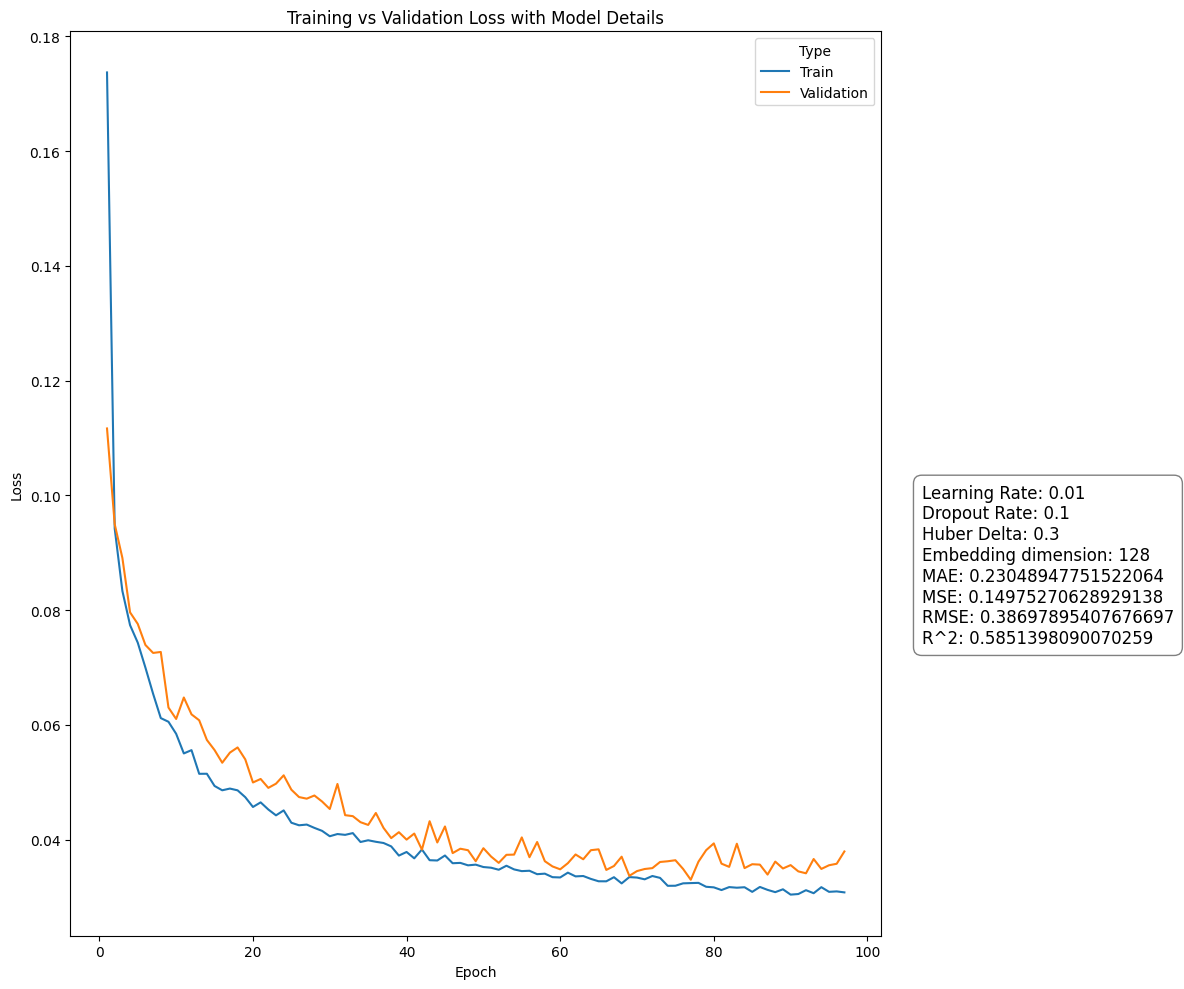

In [26]:
y_pred, model, errors = try_NN(X_train_condition, X_train_cell_line, y_train, X_val_condition, X_val_cell_line, y_val, X_test_condition, X_test_cell_line, y_test, huber_delta=0.3, dropout_rate=0.1, embedding_dim=128, disp=True, save=True, path=PATH+"Model Tuning/")

#Comparison to baseline models

In [27]:
'''

Baseline models work on Numpy vectors, so we need to move Tensors back to CPU and convert them back to NdArray.

The first baseline Model is a Random Forest Regressor (sklearn) used with a MultiOuputRegressor tool

'''

import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor

# Create the MultiOutputRegressor
base_regressor = RandomForestRegressor()
multioutput_regressor = MultiOutputRegressor(base_regressor)

X_train = model.encode(X_train_condition, X_train_cell_line)
X_train_numpy = X_train.detach().to("cpu").numpy()
y_train_numpy = y_train.detach().to("cpu").numpy()

# Train the model
multioutput_regressor.fit(X_train_numpy, y_train_numpy)

MultiOutputRegressor(estimator=RandomForestRegressor())

In [28]:
# Making predictions with RandomForestRegressor
X_test_baseline = model.encode(X_test_condition, X_test_cell_line).detach().to("cpu").numpy()
y_pred_rf = multioutput_regressor.predict(X_test_baseline)
y_test_numpy = y_test.detach().to("cpu").numpy()

# Evaluate the model
mae_forest = mean_absolute_error(y_test_numpy, y_pred_rf)
mse_forest = mean_squared_error(y_test_numpy, y_pred_rf)
rmse_forest = np.sqrt(mse_forest)
r2_forest = r2_score(y_test_numpy, y_pred_rf)
print(f"MAE: {mae_forest}\nMSE: {mse_forest}\nRMSE: {rmse_forest}\nR^2: {r2_forest}")

MAE: 0.1522583797048354
MSE: 0.07977598488944232
RMSE: 0.28244642835313444
R^2: 0.7665304536263525


In [29]:
'''

LightGBM doesn't have a built-in multi-output tool, so we had to build on ourselves.
It basically trains as many LightGBM Regressor as need in a sequential manner.

'''

import lightgbm as lgb

class MultiOutputLGBM:
    def __init__(self, model_params=None):
        self.models = []
        if model_params is None:
            self.model_params = {}
        else:
            self.model_params = model_params

    def fit(self, X, Y):
        self.models = [lgb.LGBMRegressor(**self.model_params) for _ in range(Y.shape[1])]
        for i, model in enumerate(self.models):
            model.fit(X, Y[:, i])

    def predict(self, X):
        predictions = [model.predict(X) for model in self.models]
        return np.column_stack(predictions)

# Usage
multioutput_lgbm = MultiOutputLGBM({'verbosity':0})
multioutput_lgbm.fit(X_train_numpy, y_train_numpy)
y_pred_lgbm = multioutput_lgbm.predict(X_test_baseline)

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


In [30]:
# Evaluate the model
mae_lgbm = mean_absolute_error(y_test_numpy, y_pred_lgbm)
mse_lgbm = mean_squared_error(y_test_numpy, y_pred_lgbm)
rmse_lgbm = np.sqrt(mse_forest)
r2_lgbm = r2_score(y_test_numpy, y_pred_lgbm)
print(f"MAE: {mae_lgbm}\nMSE: {mse_lgbm}\nRMSE: {rmse_lgbm}\nR^2: {r2_lgbm}")

MAE: 0.1547565153002974
MSE: 0.08125430234625942
RMSE: 0.28244642835313444
R^2: 0.7608736852927888


#Scoring from the Synapse challenge

This section was our attempt at using the scoring method from the challenge. As mentionned, this was made impossible because we didn't have access to the groundtruth used by the challengemakers.

In these cells, you'll find an try of the scoring method from the challenge, on one random cell line that we single out for testing purposes. This whole **section is irrelevant** to the project now.

In [ ]:
X_test_condition_numpy = X_test_condition.cpu().numpy()
X_test_cell_line_numpy = X_test_cell_line.cpu().numpy()
y_test_numpy = y_test.cpu().numpy()
y_pred_numpy = y_pred.copy()

In [ ]:
def decode_one_hot(one_hot_encoded, categories):
    # Find the index with the maximum value in each one-hot encoded row
    indices = np.argmax(one_hot_encoded, axis=1)

    # Map the indices back to the original categories
    decoded_values = [categories[i] for i in indices]

    return np.array(decoded_values)

def split_condition(conditions):
  ret = []
  for condition in conditions:
    ret.append(condition.split("_"))
  return np.array(ret)

X_test_condition_decoded = split_condition(decode_one_hot(X_test_condition_numpy,encoder_condition.categories_[0]))
X_test_cell_line_decoded = decode_one_hot(X_test_cell_line_numpy, encoder_cell_line.categories_[0])

x_test_numpy = []

for i in range(X_test_condition_decoded.shape[0]):
  x_test_numpy.append([X_test_condition_decoded[i][0], X_test_condition_decoded[i][1], X_test_cell_line_decoded[i]])

def strip_suffix(s):
    return s.split('_')[0]

markers = np.vectorize(strip_suffix)(concatenated_df.columns.values[:37])
columns = np.hstack([np.array(['treatment', 'time', 'cell_line']) , markers])
x_test_numpy = np.array(x_test_numpy)

In [ ]:
x_test_df = pd.DataFrame(x_test_numpy, columns=['treatment', 'time', 'cell_line'])
y_test_df = pd.DataFrame(y_test_numpy, columns=concatenated_df.columns)
y_pred_df = pd.DataFrame(y_pred_numpy, columns=concatenated_df.columns)
validations_stats = pd.concat([x_test_df, y_test_df], axis=1)
predictions_stats = pd.concat([x_test_df, y_pred_df], axis=1)

In [ ]:
# Function to sample values
def sample_values(row, markers):
    samples = []
    for marker in markers:
        mean = row[f'{marker}_mean']
        variance = row[f'{marker}_var']
        sampled_values = np.random.normal(mean, np.sqrt(variance), 10000)
        samples.append(sampled_values)
    return np.array(samples).T

def sample_and_save(df, markers, path, filename):
  new_rows = []
  for index, row in df.iterrows():
      identifiers = row[:3]  # First 3 columns are treatment, time and cell line
      sampled_data = sample_values(row, markers)
      for sample in sampled_data:
          new_row = np.concatenate([identifiers, sample])
          new_rows.append(new_row)

  new_df = pd.DataFrame(new_rows, columns=['treatment', 'time', 'cell_line'] + [f'{marker}' for marker in markers])
  filename = filename + ".csv"
  new_df.to_csv(path + filename, index=False)

In [ ]:
for cell_line, df in predictions_stats.groupby("cell_line"):
  sample_and_save(df, markers, PATH, cell_line+"_pred")
  break
for cell_line, df in validations_stats.groupby("cell_line"):
  sample_and_save(df, markers, PATH, cell_line+"_val")
  break

In [ ]:
import pandas as pd
import numpy as np

def flatten_cov_matrix(covmat):
    rows, cols = np.triu_indices(covmat.shape[0])
    return pd.DataFrame({
        'stat_variable': ['cov_' + str(i) + '_' + str(j) for i, j in zip(rows, cols)],
        'stat_value': covmat[rows, cols]
    })

def data_to_stats(single_cell_data):
    grouped = single_cell_data.groupby(['cell_line', 'treatment', 'time'])[single_cell_data.columns.values.tolist()[3:]]

    all_stats = []
    for name, group in grouped:
        mean_values = group.mean().reset_index()
        cov_values = group.cov()

        mean_values.columns = ["stat_variable", "stat_value"]
        mean_values['stat_variable'] = 'mean_' + mean_values['stat_variable']
        vec_cov = flatten_cov_matrix(cov_values.values)

        all_stats.append(pd.concat([mean_values, vec_cov], axis=0).assign(cell_line=name[0], treatment=name[1], time=name[2]))

    return pd.concat(all_stats, axis=0)

In [ ]:
from scipy.spatial.distance import euclidean

def score_subchallenge_2(prediction_data_file, validation_data_file):
    validation_data = pd.read_csv(validation_data_file)
    prediction_data = pd.read_csv(prediction_data_file)

    # Required columns check
    required_columns = ['cell_line', 'treatment', 'time',
                        'b.CATENIN', 'cleavedCas', 'CyclinB', 'GAPDH', 'IdU',
                        'Ki.67', 'p.4EBP1', 'p.Akt.Ser473.', 'p.AKT.Thr308.',
                        'p.AMPK', 'p.BTK', 'p.CREB', 'p.ERK', 'p.FAK', 'p.GSK3b',
                        'p.H3', 'p.JNK', 'p.MAP2K3', 'p.MAPKAPK2',
                        'p.MEK', 'p.MKK3.MKK6', 'p.MKK4', 'p.NFkB', 'p.p38',
                        'p.p53', 'p.p90RSK', 'p.PDPK1', 'p.RB',
                        'p.S6', 'p.S6K', 'p.SMAD23', 'p.SRC', 'p.STAT1',
                        'p.STAT3', 'p.STAT5']
    if not all(col in prediction_data.columns for col in required_columns):
        raise Exception("Missing columns detected. Required columns: " + ', '.join(required_columns))

    prediction_data = prediction_data[required_columns]
    validation_data = validation_data[required_columns]

    # Checking for any missing conditions
    required_conditions = validation_data[['cell_line', 'treatment', 'time']].drop_duplicates()
    predicted_conditions = prediction_data[['cell_line', 'treatment', 'time']]

    missing_conditions = required_conditions.merge(predicted_conditions, on=['cell_line', 'treatment', 'time'], how='outer', indicator=True).loc[lambda x: x['_merge'] == 'left_only']
    if not missing_conditions.empty:
        print(missing_conditions[['cell_line', 'treatment', 'time']])
        raise Exception("Missing predictions detected for above conditions")

    validation_stats = data_to_stats(validation_data).rename(columns={'stat_value': 'test_stat_value'})
    prediction_stats = data_to_stats(prediction_data).rename(columns={'stat_value': 'predicted_stat_value'})

    combined_data = validation_stats.merge(prediction_stats, on=['cell_line', 'treatment', 'time', 'stat_variable'])

    # Calculate score
    final_score = euclidean(combined_data['test_stat_value'], combined_data['predicted_stat_value'])
    return final_score


In [ ]:
score_subchallenge_2(PATH + "184A1_pred.csv", PATH + "184A1_val.csv")

12.384023310295126